In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
import re
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

In [2]:
data = pd.read_csv('C:\\Users\Katy\Documents\VK\ML-инженер\\train_spam.csv')
data.isnull().sum()

text_type    0
text         0
dtype: int64

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [4]:
data['clean_text'] = data['text'].apply(preprocess_text)
data['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

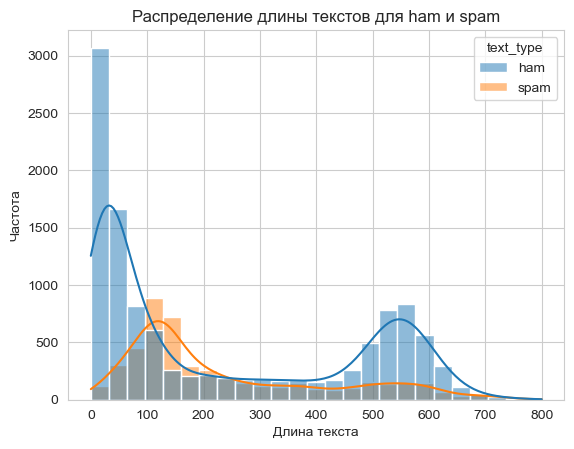

In [5]:
data['text_length'] = data['clean_text'].apply(len)
sns.histplot(data=data, x='text_length', hue='text_type', bins=25, kde=True)
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.title('Распределение длины текстов для ham и spam')
plt.show()

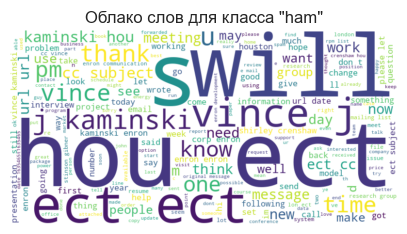

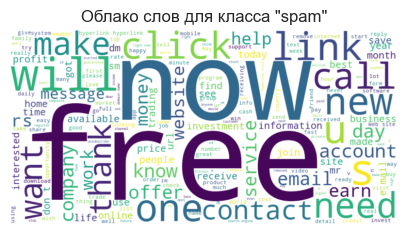

In [6]:
ham_text = ' '.join(data[data['text_type'] == 'ham']['text'])
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

spam_text = ' '.join(data[data['text_type'] == 'spam']['text'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(5, 3))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Облако слов для класса "ham"')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 3))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Облако слов для класса "spam"')
plt.axis('off')
plt.show()

In [7]:
X = data['text']
y = data['text_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Логиcтическая регрессия

In [11]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

y_pred_proba = logreg.predict_proba(X_test_tfidf)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC для логистической регрессии:", roc_auc)

ROC AUC для логистической регрессии: 0.9788487812970161


Наивный Байесовский классификатор

In [13]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

y_pred_proba_nb = nb_classifier.predict_proba(X_test_tfidf)[:, 1]

roc_auc_nb = roc_auc_score(y_test, y_pred_proba_nb)
print("ROC AUC для наивного Байесовского классификатора:", roc_auc_nb)

ROC AUC для наивного Байесовского классификатора: 0.9684517322655043


CNN

In [14]:
seed = 555
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['text_type'])

In [17]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [18]:
data['text_clean'] = data['text'].apply(clean_text)
data.head()

,text_type,text,clean_text,text_length,label,text_clean
0,ham,make sure alex knows his birthday is over in f...,make sure alex knows birthday fifteen minutes ...,65,0,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...,resume john lavorato thanks vince get moving r...,400,0,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...,plzz visit website moviesgodml get movies free...,99,1,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...,urgent mobile number awarded £2000 prize guara...,108,1,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...,overview hr associates analyst project per dav...,632,0,overview of hr associates analyst project per ...


In [19]:
data['text_tokens'] = data['text_clean'].str.split()

In [20]:
word_freq = defaultdict(int)
for tokens in data['text_tokens']:
    for token in tokens:
        word_freq[token] += 1

sorted_vocab = sorted(word_freq, key=word_freq.get, reverse=True)
vocab = {word: i + 1 for i, word in enumerate(sorted_vocab)}

In [21]:
def tokens_to_indices(tokens):
    return [vocab[token] if token in vocab else 0 for token in tokens]

In [22]:
data['text_indices'] = data['text_tokens'].apply(tokens_to_indices)
data[['text_clean', 'text_tokens', 'text_indices']].head()

,text_clean,text_tokens,text_indices
0,make sure alex knows his birthday is over in f...,"[make, sure, alex, knows, his, birthday, is, o...","[99, 265, 840, 1797, 116, 2677, 11, 136, 9, 68..."
1,a resume for john lavorato thanks vince i will...,"[a, resume, for, john, lavorato, thanks, vince...","[5, 271, 10, 211, 4296, 72, 22, 3, 29, 47, 163..."
2,plzz visit my website moviesgodml to get all m...,"[plzz, visit, my, website, moviesgodml, to, ge...","[8121, 195, 30, 276, 25303, 2, 47, 40, 1367, 1..."
3,urgent your mobile number has been awarded wit...,"[urgent, your, mobile, number, has, been, awar...","[906, 14, 510, 200, 62, 91, 2424, 17, 5, 44, 1..."
4,overview of hr associates analyst project per ...,"[overview, of, hr, associates, analyst, projec...","[3111, 8, 1171, 1368, 1026, 283, 296, 455, 25,..."


In [23]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data['text_indices'], data['label'], test_size=0.3, random_state=42)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)

In [24]:
def create_padded_tensor(data_list):
    return pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in data_list], batch_first=True, padding_value=0)

In [25]:
train_tensor = create_padded_tensor(train_data)
val_tensor = create_padded_tensor(val_data)
test_tensor = create_padded_tensor(test_data)

train_labels_tensor = torch.tensor(train_labels.tolist(), dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.tolist(), dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels.tolist(), dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, dropout_rate=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_size, 128, 5, padding=2)
        self.conv2 = nn.Conv1d(128, 128, 5, padding=2)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.batch_norm1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.batch_norm2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.mean(x, 2)
        x = self.fc(x)
        return x

In [27]:
vocab_size = len(vocab) + 1
embed_size = 100
num_classes = 2

In [28]:
model = TextCNN(vocab_size, embed_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)

In [29]:
def train_epoch(model, device, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, device, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = [] 

    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probabilities = torch.softmax(outputs, dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())

    average_loss = total_loss / len(data_loader)

    accuracy = accuracy_score(all_labels, all_predictions)
    try:
        auc_roc = roc_auc_score(all_labels, all_probabilities)
    except ValueError:
        auc_roc = float('nan')

    return average_loss, accuracy, auc_roc

In [34]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_epoch(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_auc_roc = evaluate_model(model, device, val_loader, criterion)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC ROC: {val_auc_roc:.4f}')

Epoch 1, Train Loss: 0.0182, Val Loss: 0.2907, Val Accuracy: 0.9345, Val AUC ROC: 0.9752
Epoch 2, Train Loss: 0.0140, Val Loss: 0.3240, Val Accuracy: 0.9369, Val AUC ROC: 0.9781
Epoch 3, Train Loss: 0.0183, Val Loss: 0.3060, Val Accuracy: 0.9345, Val AUC ROC: 0.9759
Epoch 4, Train Loss: 0.0255, Val Loss: 0.2614, Val Accuracy: 0.9394, Val AUC ROC: 0.9788
Epoch 5, Train Loss: 0.0118, Val Loss: 0.2660, Val Accuracy: 0.9386, Val AUC ROC: 0.9795
Epoch 6, Train Loss: 0.0066, Val Loss: 0.3223, Val Accuracy: 0.9337, Val AUC ROC: 0.9796
Epoch 7, Train Loss: 0.0060, Val Loss: 0.3139, Val Accuracy: 0.9369, Val AUC ROC: 0.9763
Epoch 8, Train Loss: 0.0094, Val Loss: 0.3229, Val Accuracy: 0.9353, Val AUC ROC: 0.9789
Epoch 9, Train Loss: 0.0081, Val Loss: 0.3234, Val Accuracy: 0.9312, Val AUC ROC: 0.9779
Epoch 10, Train Loss: 0.0078, Val Loss: 0.2883, Val Accuracy: 0.9357, Val AUC ROC: 0.9794


In [35]:
test_loss, test_accuracy, test_auc_roc = evaluate_model(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC ROC: {test_auc_roc:.4f}')

Test Loss: 0.2765, Test Accuracy: 0.9439, Test AUC ROC: 0.9796


Имеем след. значения ROC AUC:
Логистич. регрессия - 0.9788
Наивный Байесовский - 0.9684
CNN - 0.9798

In [37]:
test_data = pd.read_csv("C:\\Users\Katy\Documents\VK\ML-инженер\\test_spam.csv")

In [47]:
test_data['text_clean'] = test_data['text'].apply(clean_text)
test_data['text_tokens'] = test_data['text_clean'].str.split()
test_data['text_indices'] = test_data['text_tokens'].apply(tokens_to_indices)

In [48]:
test_tensor = create_padded_tensor(test_data['text_indices'])
test_dataset = TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
model.eval()
all_predictions = []

with torch.no_grad():
    for texts in test_loader:
        texts = texts[0].to(device)
        outputs = model(texts)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        all_predictions.extend(predicted_labels.cpu().numpy())

In [53]:
predicted_labels_text = label_encoder.inverse_transform(all_predictions)
test_data['text_type'] = predicted_labels_text
test_data[['text_type', 'text']].to_csv('predicted_spam_labels.csv', index=False)